#Part 4
##An Image Classifier for Rock, Paper, Scissors
Lawrence Oks

---

Remember this?

![alt text](https://imgur.com/YZ9gjeG.png)

Earlier we discussed how difficult it might be to write a program that could recognize hands of different shapes, sizes, ethnicities, and more for something as simple as rock, paper, scissors. 

But since then, we've becoming machine learning experts! Learned how to build neural networks, first to detect patterns in raw pixels and then detect features using convolutions. 

Let's put it all together and train a model that can detect and spot rock, paper, and scissors.

##Let's get started!
We'll start by downloading a rock, paper, scissors dataset to train  with (one for training and one for testing):

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2020-02-06 18:20:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M  62.5MB/s    in 3.1s    

2020-02-06 18:20:51 (62.5 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2020-02-06 18:20:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/tmp/rps-

We'll use python's built in ```zipfile``` library to unzip them, and store them in a temp directory like this:

In [ ]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

It's important to make sure your dataset looks how you expected. Let's quickly print out some validation of that before we move on:

In [ ]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock02-072.png', 'rock07-k03-102.png', 'rock07-k03-089.png', 'rock02-030.png', 'rock03-035.png', 'rock07-k03-021.png', 'rock04-061.png', 'rock05ck01-066.png', 'rock06ck02-075.png', 'rock06ck02-031.png']
['paper04-038.png', 'paper01-103.png', 'paper07-006.png', 'paper04-006.png', 'paper02-118.png', 'paper03-050.png', 'paper07-052.png', 'paper03-036.png', 'paper07-086.png', 'paper03-014.png']
['scissors04-114.png', 'scissors02-022.png', 'scissors02-030.png', 'testscissors02-097.png', 'scissors02-024.png', 'scissors01-109.png', 'scissors04-051.png', 'scissors03-119.png', 'scissors04-039.png', 'testscissors01-051.png']


Unzipping them creates folders and sub-folders of each of our categories. When training in TensorFlow using an image data generator, we will automatically label the images based on the name of their parent directory. So, we don't need to create labels for the images, a really nice shortcut.

![alt text](https://imgur.com/75kf8Hq.png)

We'll achieve that with this code. This creates an image data generator that generates images for the training from the directory that they were donloaded to. We can then set up a **training generator**, which creates training data from that. 

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

Found 2520 images belonging to 3 classes.


We can do exactly the same for the test data with this code:

In [ ]:
VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

Found 372 images belonging to 3 classes.


Now lets look at our neural network definition! It's like what we've seen previously, just with some more layers. 

One reason for this is that the images now are more complicated than the grayscale pictures we were using before. Another is that they're much bigger: 150 x 150, versus the 28 x 28 previously. 

And our output is a layer of 3 neurons. Why? 

Between that input and output is pretty similar to what we've already seen. No we have four layers of convolutions, each with Max-Pooling before feeding into a Dense Layer. 

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________

The **Dropout** is a little trick to improve the efficiency of a neural network by throwing away some of the neurons while training.

We'll compile the neural network just like before: 

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

Then we'll fit the data. Notice this one looks a little different: this time we don't have labels, because we're using the generator to infer the labels from the parent directories for both training and validation(testing). 

In [ ]:
history = model.fit_generator(train_generator, epochs=20, validation_data = validation_generator, verbose = 1)

Epoch 1/20
79/79 [==============================] - 191s 2s/step - loss: 1.1697 - acc: 0.3778 - val_loss: 0.9206 - val_acc: 0.4140
Epoch 2/20
79/79 [==============================] - 189s 2s/step - loss: 0.9008 - acc: 0.5825 - val_loss: 0.3831 - val_acc: 0.7742
Epoch 3/20
79/79 [==============================] - 188s 2s/step - loss: 0.6137 - acc: 0.7448 - val_loss: 0.1765 - val_acc: 0.9570
Epoch 4/20
79/79 [==============================] - 189s 2s/step - loss: 0.3766 - acc: 0.8516 - val_loss: 0.2380 - val_acc: 0.9946
Epoch 5/20
79/79 [==============================] - 189s 2s/step - loss: 0.3153 - acc: 0.8849 - val_loss: 0.0934 - val_acc: 0.9731
Epoch 6/20
79/79 [==============================] - 189s 2s/step - loss: 0.2374 - acc: 0.9179 - val_loss: 0.0441 - val_acc: 0.9919
Epoch 7/20
79/79 [==============================] - 188s 2s/step - loss: 0.2069 - acc: 0.9274 - val_loss: 0.1315 - val_acc: 0.9946
Epoch 8/20
79/79 [==============================] - 186s 2s/step - loss: 0.1649 - a

And we'll even save the model this time to a file, like this: 

In [ ]:
model.save("rps.h5")

##Overfitting

You'll notice if we run this that we will probably quickly get to an accuracy of about 100% on the training data, but only about 87% on the testing set. This is called **overfitting**, which happens when the model gets really good at spotting what it's seen before, but not good at generalizing for new data it has to predict. 

This is a really important topic in ML and depending on the type of problem you're trying to solve, there are many different ways to solve overfitting. 

Here's some math code to display how well our training and testing went over time:

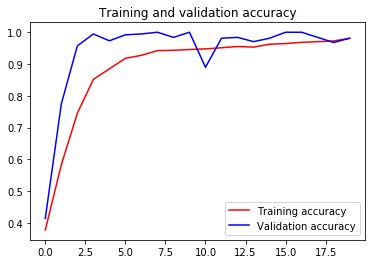

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

##Let's see it in action

And if all has worked well, we'll be able to upload a picture of a rock, paper, or scissors and our model can predict what it is. 

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving scissors.png to scissors (1).png
scissors.png
[[0. 0. 1.]]
